# Introduction

Access to bank loans plays a critical role in enabling individuals and businesses to finance important expenses, from home purchases to entrepreneurial ventures. This blog post explores the landscape of bank lending, focusing on the factors influencing loan approval, interest rates, and default risks. Variables such as loan intent were explored across age groups, as well as the variables affecting load grade. High grade loans (A) are associated with individuals at low risk of defaulting. Through exploratory data analysis income, loan amount, loan as a percent of income, loan interest rate, and past default hisotry were identified as variables most stronly associated with loan quality. Weigthed variables that took into account past default history as well as percent income, loan amount, and interst rate were also generated. Linear Regression was then used to determine the combination of these variables that could most accurately predict whether or not a loaner would default. The weight vector for these variables was taken to build a linear score function, and the score function threshold was optimized to maximize bank profit per buyer in the final model. In the final model, loan as a percent of income, loan interest weight, weighted interest rate, and past default history were selected as predictors with a threshold of t = 2.2, resulting in an expected profit per buyer of 1294.33.

# Data Exploration

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# load the raw bank data and clean it
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

# drop rows with NA values
df_train = df_train.dropna()

# convert the interest rate to a percent
df_train["loan_int_rate"] = df_train["loan_int_rate"] / 100

# make a copy of the data to use and view
df_ = df_train.copy()
df_.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,27,98000,RENT,3.0,EDUCATION,C,11750,0.1347,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,0.0751,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,0.1287,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,0.0963,0,0.28,N,10
6,21,21700,RENT,2.0,HOMEIMPROVEMENT,D,5500,0.1491,1,0.25,N,2


Lets explore how loan intent varies across age groups

Text(0.5, 1.0, 'Loan Intent by Age')

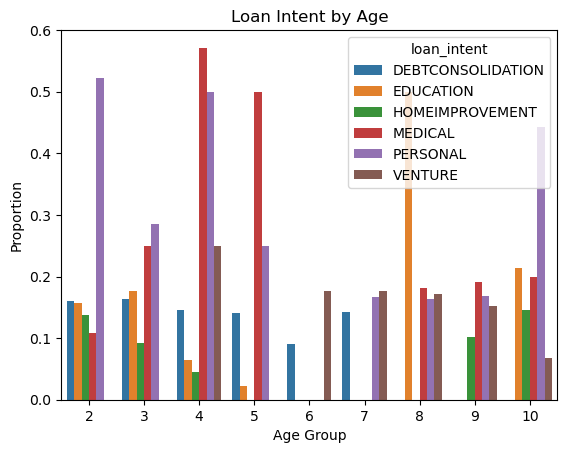

In [ ]:
# first lets add a column for age groups by creating age groups with 10 year ranges (ex. 20 - 29 is group 2)
df_["age_group"] = df_["person_age"] // 10
df_["age_group"][df_["age_group"] >= 10 ] = 10 # group all loaners older than 100 into a single group

# Get the counts of each loan intent within each age group
loan_intent_counts = df_.groupby("age_group")["loan_intent"].value_counts().unstack()
loan_intent_counts = loan_intent_counts.fillna(0) # fill NA values with 0 instead

# Convert counts to proportions relative to each age group
loan_intent_prop = loan_intent_counts.div(loan_intent_counts.sum(axis=1), axis=0)

# conert the table into long format so that each loan intent can be plotted for each age group
temp = pd.melt(loan_intent_prop)

temp["age_group"] = 0 # rebuild the age group category exactly as calculated previosly
for i in range(0, len(temp) + 1):
  temp["age_group"][i] = (i % 9) + 2

# plot loan intent as a proportion of each age group
ax = sns.barplot(data = temp, x = "age_group", y = "value", hue = "loan_intent")
ax.set_xlabel("Age Group")
ax.set_ylabel("Proportion")
ax.set_title("Loan Intent by Age")

The chart indicates that personal loans are most common among individuals aged 20-29, 40-49, and 90-99, suggesting a consistent need for general-purpose borrowing across different life stages. Medical loans peak in the 40-49 and 50-59 age groups, likely due to increasing healthcare expenses. Education loans spike in the 70-79 age group, which may indicate late-stage career shifts or funding for dependents. Debt consolidation loans are relatively steady, with moderate representation in the 30-39, 50-59, and 60-69 age groups. Home improvement loans have lower proportions overall but see slight increases among borrowers aged 20-29 and 80-89. Venture loans are sporadic, with small peaks in the 50-59 and 60-69 age groups, possibly reflecting mid-life entrepreneurial activity. These trends highlight how borrowing needs evolve across different age brackets; lets explore income relates to loan size. 

In [11]:
# make a copy of the data frame to work with and create income categories similar to our age group categories (ex. $0 - $99,999 is group 0)
df_2 = df_train.copy()
df_2["income_cat"] = df_2["person_income"] // 50000
df_2["income_cat"][df_2["income_cat"] >= 10] = 10 # group all income creater than $1,000,000 into a single group

# find the mean loan amount in each income category
print(df_2.groupby("income_cat")["loan_amnt"].mean().round())

income_cat
0      7061.0
1     10485.0
2     13356.0
3     15176.0
4     16728.0
5     19252.0
6     18127.0
7     20516.0
8     19615.0
9     17306.0
10    14535.0
Name: loan_amnt, dtype: float64


While salary (income category) does seem to affect the loan amount, with people having higher salaries taking out larger loans, the higher income categories actually often have lower loan amounts than the lower income categories. The spread of loan amount vs income fits a in some ways a bell curve. This may be a product of people making larger salaries not needing to take out loans as frequently as the middle salaries, which can afford to take out larger loans and pay them back. Let's also determine what factors seem to be related to higher interest rates.

In [ ]:
# group the data by loan grade and view the mean interest rates for each loan grade
print(df_train.groupby(["loan_grade"])["loan_int_rate"].mean())

loan_grade
A    0.073384
B    0.110033
C    0.134562
D    0.153583
E    0.170473
F    0.185190
G    0.202300
Name: loan_int_rate, dtype: float64


High grade loans (loans which are expected to be paid back) are associated with the lowest interest rates. There seems to be a direct correlation between loan grade and interest rate. Lets explore factors related to loan grades by grouping.

In [13]:
# group the data by loan grade and view the mean income, mean loan amount, and mean percent income for each load grade
temp = df_train.groupby("loan_grade")[["person_income", "loan_amnt", "loan_percent_income"]].mean()

print(temp)

            person_income     loan_amnt  loan_percent_income
loan_grade                                                  
A            66773.007816   8555.884885             0.152629
B            66662.091096  10031.025007             0.173846
C            66416.633130   9322.102794             0.168928
D            64555.473908  10821.646695             0.188833
E            70868.349432  12929.083807             0.204190
F            80756.546012  15395.705521             0.220982
G            77342.477273  17384.659091             0.243409


As we can see from this datatable, high load grade is directly correlated with lower percent of total income. Meaning that higher quality loans, with lower interest rates, are associated with loaners whose loan takes up the smallest percent of their total income. This is likely related to the loan taking up a lower percent of their income making it less likely for them to default on the loan and be more capable of paying it back. It also seems to follow that people with higher income tend to take out larger loans than would correlate with their increase income. 

# Feature Selection & Weight Assessment

Select the predictor and target variables related to loan grade.

In [14]:
from sklearn.model_selection import train_test_split

# select the predictor variables identified with loan grade. Also the include the loaners default history
predictor_cols = ["person_income", "loan_amnt", "loan_percent_income", "loan_int_rate", "cb_person_default_on_file"]
X_model = df_train[predictor_cols].copy()  # Use .copy() to avoid modifying the original DataFrame

# target variable selection
y_model = np.array(df_train["loan_status"])

# Create binary indicators for past defaults
X_model["past_default_yes"] = X_model["cb_person_default_on_file"] == "Y"
X_model["past_default_no"] = X_model["cb_person_default_on_file"] == "N"

# Generate weighted default predictor
X_model["weighted_default"] = X_model["loan_percent_income"] * (1 +  X_model["past_default_yes"])

# Generate weigthed interest rate predictor
X_model["weighted_interest"] = (1 + X_model["loan_int_rate"]) * X_model["loan_amnt"] * (1 + X_model["past_default_yes"])

# Drop the original categorical column
X_model.drop("cb_person_default_on_file", axis=1, inplace=True)

# Breaking into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2)

Fit a Linear Regression model to the data and assess its accuracy of prediction. Try all combinations of predictors. Once a good model is fit, pull out the weight coefficient to use for a linear score based classifier.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.metrics import accuracy_score

# create arrays to hold all the predictors we will consider
numerical_predictors = ["person_income", "loan_amnt", "loan_percent_income", "loan_int_rate", "weighted_default", "weighted_interest"]
qual_predictors = ["past_default_yes", "past_default_no"]
predictor_cols = numerical_predictors + qual_predictors

# create an empty array to store the accuracy results for predictor combinations
results = []

# For each combination of predictor variables train a Linear Model and assess its accuracy
for r in range(1, len(predictor_cols) + 1): # From 1 feature to all features
    for subset in combinations(predictor_cols, r): # For each combination of those features
        
        # assign the test columns
        test_cols = list(subset)
        
        # Select subset of features for the training and testing data
        X_train_subset = X_train[test_cols]
        X_test_subset = X_test[test_cols]
        
        # Train a simple logistic regression model to the subset
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_subset, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store results
        results.append({"features": test_cols, "accuracy": accuracy})

From the list of feature combinations, pull out the top 5 and retest them against the premade training and testing data. Once the best from this list has been identified, verify its accuracy with cross validation to check for overfitting. If the features pass, pull out the weights coefficient to use for a linear score based classifier. 

In [17]:
# select the top 5 feature combinations by accuracy
best_features = pd.DataFrame(results).sort_values(by = "accuracy", ascending = False).head(5)["features"].tolist()

# create an empty array to store the features that will ultimately be selected for the model as well as variable to hold the features testing accuracy
true_predictors = []
best_acc = 0

# For each of the top 5 features train a Linear Model and asses its ability to predict on the testing data. Select the features with the highest predictive accuracy as the features to use for bank profit maximization
for features in best_features:
    # fit a model to the feature list
    LR_test = LogisticRegression()
    m_test = LR_test.fit(X_train[features], y_train)

    # use the model to generate predictions on the testing data
    y_pred = LR_test.predict(X_test[features])

    # assess the accuracy of the models predictions against the testing data
    acc = accuracy_score(y_test, y_pred)

    # if the current features are better than the previous best, reassign the new best
    if acc > best_acc:
        best_acc = acc
        true_predictors = features

print("The predictors with the highest testing accuracy are: " + str(true_predictors) + "\nAccuracy = " + str(best_acc))

# Check with cross validation
LR_real = LogisticRegression()
m_real = LR_real.fit(X_train[true_predictors], y_train)

cv_scores_LR = cross_val_score(LR_real, X_test[true_predictors], y_test, cv = 5)

print("Cross validation for the selected predictors: " + str(cv_scores_LR))

# store the weight coefficients for this model to build our linear score function
w = m_real.coef_

# store the dimenstions the of weight vector as it must be reshaped to a n x 1 instead of a 1 x n
s = w.shape

# reshape the weight vector
w = w.reshape(s[1], s[0])

The predictors with the highest testing accuracy are: ['loan_percent_income', 'loan_int_rate', 'weighted_interest']
Accuracy = 0.8347883020515059
Cross validation for the selected predictors: [0.82878953 0.81788441 0.8220524  0.81659389 0.82969432]


Upon inspecting accuracy versus the overall test set income the predictors above were selected as the best variables based purely on accuracy. These predictors also had reasonable cross validation scores that were similar to the overall testing accuracy; this implies that the model is consisent and not overfit. The weight constants from this model were then pulled out and stored for later used in a linear score function. 

# Optimizing a Linear Score Classification

Start by defining our linear score function using our weight vector and our classification function with an arbitrary starting threshold. We will then optimize this threshold such that the bank makes the largest possible profit per loan.

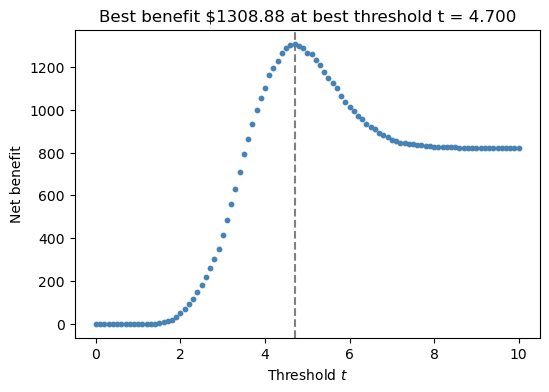

In [18]:
from matplotlib import pyplot as plt

# Performs the dot product between the data vector X and the weight vector w
def score(X, w):
    return np.dot(X,w)

# Returns the predictions of the model. 1 if the loaner is predicted to default, and 0 if they are predicted to repay the loan
def predict(score, threshold, df):
  scores = score(df, w)
  return 1*(scores > threshold)

# pull out model data
X_model = X_train.copy()

# initialize the benefit column
X_model["benefit"] = 0

# initialize variables to store the best benefit and threshold through iteration
best_benefit = 0
best_threshold = 0

# assign scores to each individual based on the features selected previously and the weight vector associated with these features
scores = score(X_model[true_predictors], w)

# generate a plot to visualize how profit changes as threshold changes
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

# for thresholds between 0 and 10
for t in np.linspace(0, 10, 101):
    
    # assign predictions based on the threshold
    X_model["y_pred"] = scores >= t

    # calculate whether each indivdual is a true negative or a false negative
    X_model["tn"] = (X_model["y_pred"] == 0) & (y_train == 0)
    X_model["fn"] = (X_model["y_pred"] == 0) & (y_train == 1)
    
    # calculate the gain/loss for each individual based on whether they are considered a true negative or a false negative
    X_model["benefit"][X_model["tn"]] = X_model["loan_amnt"] * (1 + 0.25 * X_model["loan_int_rate"]) ** 10 - X_model["loan_amnt"]
    X_model["benefit"][X_model["fn"]] = X_model["loan_amnt"] * (1 + 0.25 * X_model["loan_int_rate"]) ** 3 - 1.7 * X_model["loan_amnt"]

    # sum the total benefit across all invididuals and divide by the total number of individuals to find the average profit per loaner
    average_benefit = np.sum(X_model["benefit"]) / len(X_model)

    # add this point to the cumulative graph
    ax.scatter(t, average_benefit, color = "steelblue", s = 10)

    # if the current benefit is bette than the previous best, reassign the benefit and store the current threshold
    if average_benefit > best_benefit:
        best_benefit = average_benefit
        best_threshold = t

ax.axvline(best_threshold, linestyle = "--", color = "grey", zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Net benefit", title = f"Best benefit ${best_benefit:.2f} at best threshold t = {best_threshold:.3f}")

Maximization of the bank's profit results in a threshold of 4.7, with a profit per buyer of 1308.88. The value of the threshold has been stored for later use. Lets now test the model with our optimal weight vector and threshold against new testing data. 

In [19]:
# load the testing data
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

# drop NA columns and convert the interest rate to percent
df_test = df_test.dropna()
df_test["loan_int_rate"] = df_test["loan_int_rate"]  /100

# Create binary indicators for past defaults
df_test["past_default_yes"] = df_test["cb_person_default_on_file"] == "Y"
df_test["past_default_no"] = df_test["cb_person_default_on_file"] == "N"

# Generate weighted default predictor
df_test["weighted_default"] = df_test["loan_percent_income"] * (1 +  df_test["past_default_yes"])

# Generate weigthed interest rate predictor
df_test["weighted_interest"] = (1 + df_test["loan_int_rate"]) * df_test["loan_amnt"] * (1 + df_test["past_default_yes"])

# Drop the original categorical column
df_test.drop("cb_person_default_on_file", axis=1, inplace=True)

# initialize the benefit column
df_test["benefit"] = 0

# calculate the score array
scores = score(df_test[true_predictors],w)

# calculate predictions based on the optimal threshold
df_test["y_pred"] = scores >= best_threshold

# determine if each individual can be considered either a true negative or a false negative
df_test["tn"] = (df_test["y_pred"] == 0) & (df_test["loan_status"] == 0)    
df_test["fn"] = (df_test["y_pred"] == 0) & (df_test["loan_status"] == 1)

# calculate the gain / loss for each individual based on whether they are true negative or a true positive
df_test["benefit"][df_test["tn"]] = df_test["loan_amnt"] * (1 + 0.25 * df_test["loan_int_rate"]) ** 10 - df_test["loan_amnt"]
df_test["benefit"][df_test["fn"]] = df_test["loan_amnt"] * (1 + 0.25 * df_test["loan_int_rate"]) ** 3 - 1.7 * df_test["loan_amnt"]


# calculate the average profit per loaner based on the total benefit and the number of loaners
average_benefit = np.sum(df_test["benefit"]) / len(df_test)

print("The expected profit per buyer is: $" + str(round(average_benefit, 2)))

The expected profit per buyer is: $1239.44


The expected profit per buyer on the test set (1239.44) is only slightly lower than the expected profit per buyer on the training set (1308.88). Thus our model was able to generalize from the training set. 

# Evaluating Model Fairness

Lets explore if some loaners are more or less likely to receive loans based on their age

In [20]:
# remake age groups in 10 year gaps and calculate the difference in default prediction vs reality
# age group 2 represents loaners aged between 20 and 29 years old
df_test["age_group"] = df_test["person_age"] // 10

# calculates the difference between prediction and actual outcome of loan status (1 means predicted to default and did not, 0 represents accurate prediction, -1 represent failure to predict default)
df_test["diff"] = df_test["y_pred"] - df_test["loan_status"]

# Group by age and view mean prediction, actual default status, and the mean difference
temp = df_test.groupby("age_group")[["loan_status", "y_pred", "diff"]].mean().reset_index()
temp

,age_group,loan_status,y_pred,diff
0,2,0.228689,0.189085,-0.039604
1,3,0.204082,0.153846,-0.050235
2,4,0.200000,0.119231,-0.080769
3,5,0.261905,0.095238,-0.166667
4,6,0.500000,0.500000,0.000000
5,7,0.500000,0.000000,-0.500000


In almost all age groups, other than age group 6, the algorithm underpredicts the loan default rate. However, two age groups which are less likely to get a loan than other groups (excluding group 7 as it only has two individuals), are age group 20-29 and 30-39. Despite, the algorithim underpredicting the default rate in this age group these groups are still predicted to be much more likely to defualt than the other age groups. The algorithm also seems to underpredict default rates more as loaners grow older. Lets now look at the difficulty of getting loans based on loan intent.

<Axes: xlabel='Proportion of Loan Status', ylabel='loan_intent'>

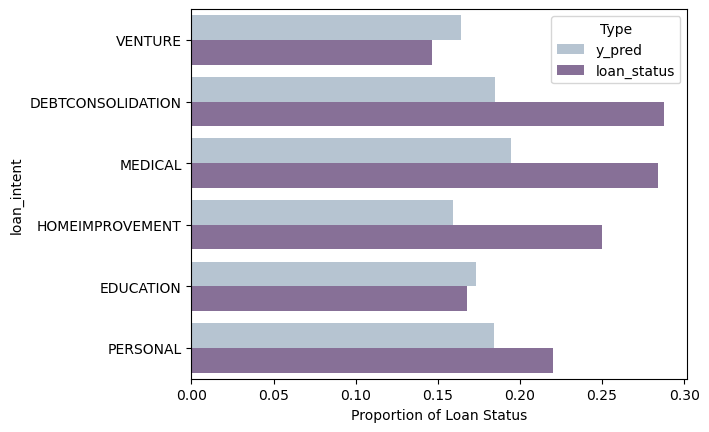

In [21]:
# create a copy dataset to work with
temp2 = df_test.copy()

# convert the data to long format so that both prediction and actual default outcome can be viewed for each loan intent
temp2_melted = pd.melt(temp2, id_vars = "loan_intent", value_vars = ["y_pred", "loan_status"], var_name = "Type", value_name = "Proportion of Loan Status")

# Generate a bar plot of defualt prediction rate  vs actual default rate for each loan type
sns.barplot(data = temp2_melted, y = "loan_intent", x = "Proportion of Loan Status", hue = "Type", palette = "BuPu", saturation = 0.5, orient = "h", errorbar = None)

Medical, Debt Consolidation, and Personal loans have the highest predicted default rate making them the hardes loans to get; however both Medical and Debt Consolidation loans do have the highest actual default rate. Education and Venture are the next hardest loans to get. Interestingly, both Venture and Education loans are preidcted to default more than they actually do and are the only loan type to display this behavior. Home Improvement loans are predicted to default the least, despite having the third highest actual default rate. Now, lets examine how gross income affects the ease with which credit can be obtained. 

<Axes: xlabel='income_group', ylabel='Proportion of Loan Status'>

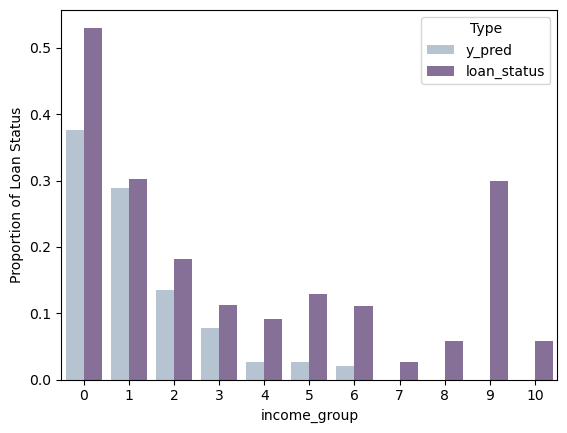

In [24]:
# create a copy dataset to work with
temp3 = df_test.copy()

# Group income into categories separated by $25,000 in income (ex. group 1: loaners making up to $24,999)
temp3["income_group"] = temp3["person_income"] // 25000
temp3["income_group"][temp3["income_group"] >= 10 ] = 10 # assign all loaners making $250,000 or more into one group

# convert the data to long format so that both prediction and actual default outcome can be viewed for income group
temp3_melted = pd.melt(temp3, id_vars = "income_group", value_vars = ["y_pred", "loan_status"], var_name = "Type", value_name = "Proportion of Loan Status")

# Generate a bar plot of defualt prediction rate vs actual default rate for each income group
sns.barplot(data = temp3_melted, x = "income_group", y = "Proportion of Loan Status", hue = "Type", palette = "BuPu", saturation = 0.5, errorbar = None)

In this model, lower income is strongly associated with greater likelihood to default, making it much harder get loans at low income. While lower income is generally associated with higher default rates, it is unrealistic that the model predicts loaners making more than 75,000 to pay back their loans 100% of the time. In fact, the second highest default rate is actually in the 200,000 - 224,999 income category.

# Conclusion

Our analysis revealed that income stability, credit history, and collateral availability are the most significant determinants in securing a loan. Borrowers with lower credit scores or irregular income streams often struggle to obtain loans or face significantly higher interest rates. While banks aim to mitigate risks through stringent approval processes, these measures inadvertently create barriers for individuals in need, particularly those seeking medical loans or small business financing.

Individuals seeking loans for medical expenses often face greater difficulties in obtaining credit due to the high default rates associated with medical debt. From a financial standpoint, banks perceive these loans as high-risk due to the uncertainty surrounding medical outcomes and the borrower's ability to repay. However, this raises ethical concerns regarding fairness in credit access. Fairness, in this context, can be defined as the equitable opportunity for all individuals to obtain financial assistance without undue discrimination or excessive barriers.

Given that medical expenses are often urgent and unavoidable, it is arguably unjust that those in dire need of healthcare financing encounter significant hurdles. A fairer approach could involve government-backed loan programs, flexible repayment structures, or the integration of medical hardship considerations into lending criteria. By reassessing how medical loans are evaluated, financial institutions can contribute to a system that balances risk management with social responsibility.